In [1]:
from os import listdir, chdir

In [147]:
import matplotlib.pyplot as plt


In [2]:
import sqlite3
import pandas as pd
import numpy as np

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [4]:
def retrieve(c,name):
    query = """SELECT * FROM {}""".format(name) + ";"
    c.execute(query)
    
    rows = c.fetchall()
    data = []
    for row in rows:
        data.append(row)
    return data

In [5]:
chdir('./data')

In [6]:
conn = sqlite3.connect('ETF.db')

c = conn.cursor()

#### Get and Clean Data for 1 stock

In [7]:
a = retrieve(c,'AAAU')

In [12]:
columns = ['Date','Open','High','Low','Close','Adj_Close','Volume']
data = pd.DataFrame(a, columns = columns)
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2018-08-13,11.84,11.84,11.74,11.82,11.82,b'\xc4\xc0\x07\x00\x00\x00\x00\x00'
1,2018-08-20,11.88,12.08,11.85,12.05,12.05,b'\x08\xe9\x04\x00\x00\x00\x00\x00'
2,2018-08-27,12.06,12.13,11.97,12.00,12.00,b'\x94T\x12\x00\x00\x00\x00\x00'
3,2018-09-03,11.91,12.07,11.90,11.96,11.96,b'X\x83\x10\x00\x00\x00\x00\x00'
4,2018-09-10,11.97,12.12,11.88,11.93,11.93,b'\x8ch\x01\x00\x00\x00\x00\x00'


In [16]:
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
#Convert byte values in Volume to int 
data['Volume'] = [int.from_bytes(value, byteorder = 'little') for value in data['Volume']]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       105 non-null    datetime64[ns]
 1   Open       105 non-null    float64       
 2   High       105 non-null    float64       
 3   Low        105 non-null    float64       
 4   Close      105 non-null    float64       
 5   Adj_Close  105 non-null    float64       
 6   Volume     105 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 5.9 KB


Text(0, 0.5, 'Price')

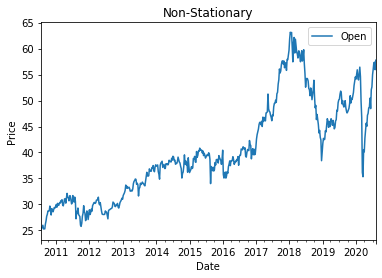

In [149]:
data.plot('Date','Open',kind = 'line')
plt.title('Non-Stationary')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

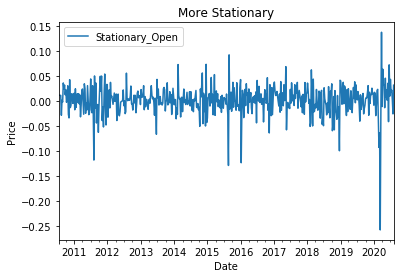

In [154]:
data['Stationary'] = np.log(data['Open']).diff(periods=1)[1:]
data.plot('Date','Stationary_Open',kind = 'line')
plt.title('More Stationary')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

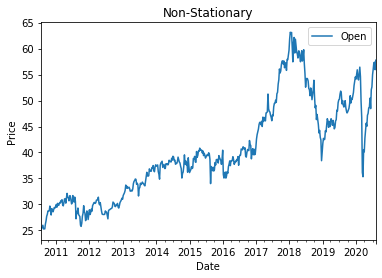

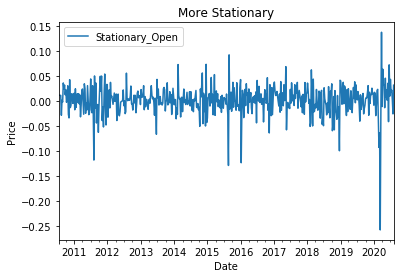

In [183]:
data.plot('Date','Open',kind = 'line')
plt.title('Non-Stationary')
plt.ylabel('Price')

data['Stationary_Open'] = np.log(data['Open']).diff(periods=1)[1:]
data.plot('Date','Stationary_Open',kind = 'line')
plt.title('More Stationary')
plt.ylabel('Price')

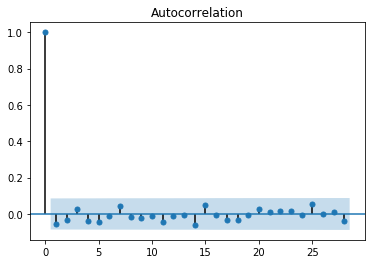

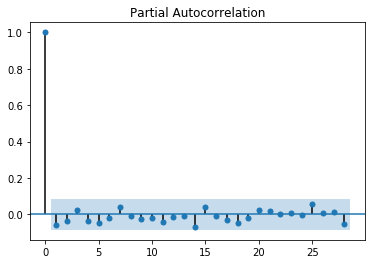

In [186]:
plot_acf(data['Stationary'][1:])
plot_pacf(data['Stationary'][1:])
print()

In [187]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
ARIMA()

In [203]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(data['Open']), order = (1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Open   No. Observations:                  525
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1116.970
Method:                       css-mle   S.D. of innovations              0.029
Date:                Sun, 06 Sep 2020   AIC                          -2225.940
Time:                        18:34:55   BIC                          -2208.887
Sample:                             1   HQIC                         -2219.262
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0014      0.000      7.739      0.000       0.001       0.002
ar.L1.D.Open     0.9599      0.013     74.365      0.000       0.935       0.985
ma.L1.D.Open    -1.0000      0.005   -194.089      0.000      -1.010      -0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0418           +0.0000j            1.0418            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [213]:
forecast = model.forecast(10)
np.exp(forecast[0])

array([57.77318638, 57.79870571, 57.82646788, 57.85638661, 57.88837926,
       57.92236671, 57.95827314, 57.99602592, 58.03555545, 58.07679506])

In [205]:
a = data['Stationary'].copy()
a

0           NaN
1      0.011881
2      0.011742
3      0.011606
4     -0.028083
         ...   
521    0.018564
522    0.021901
523    0.002269
524   -0.025421
525    0.032022
Name: Stationary, Length: 526, dtype: float64

In [216]:
from fbprophet import Prophet

In [226]:
prophet_data = data.loc[:, ['Date','Open']]

In [230]:
prophet_data['Open'] = np.log(prophet_data['Open'])

In [233]:
prophet_data.diff(periods = 1)[1:]

,Date,Open
1,7 days,0.011881
2,7 days,0.011742
3,7 days,0.011606
4,7 days,-0.028083
5,7 days,0.001976
...,...,...
521,7 days,0.018564
522,7 days,0.021901
523,7 days,0.002269
524,7 days,-0.025421


In [ ]:
prophet_data.rename(columns = {'Date': 'ds', 'Open': })

In [234]:
m = Prophet()
m.fit(prophet_data.diff(periods = 1)[1:])

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.